In [1]:
import time
import toml
import numpy as np
import matplotlib.pyplot as plt
from ref_trajectory import plot_smooth_route
from ref_trajectory import generate_trajectory as traj
from astar import gen_astar_path, plot_astar
from route_directions import make_route,euclidean
from collision_dwa import simulate_unicycle,track,plot_final_path,plot_wvk
from environment_setup import grid_from_map,place_obstacles,plot_environment,densify_grid
%matplotlib inline

config_params = toml.load("config.toml")['params']
locals().update(config_params)

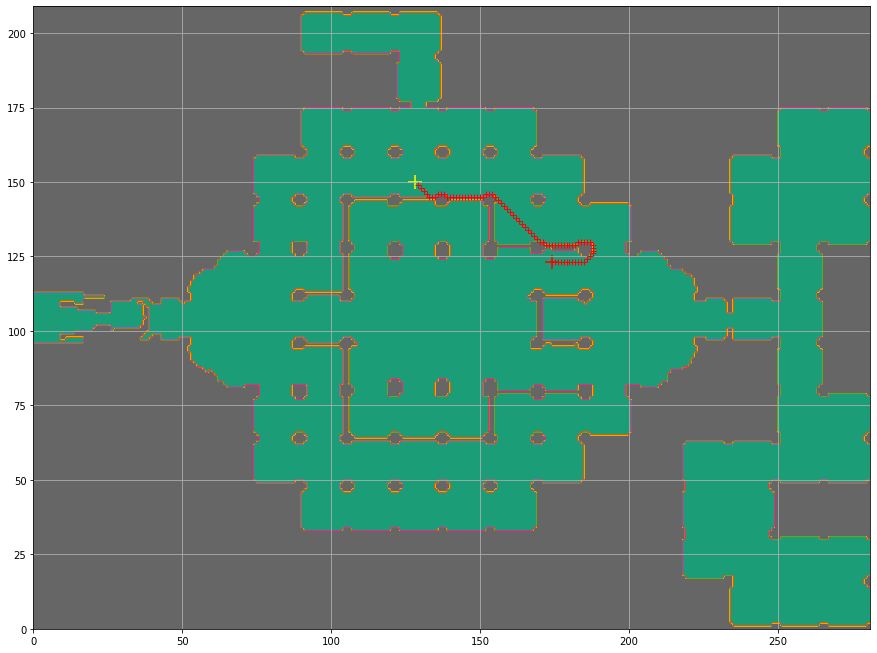

In [2]:
data = np.loadtxt("arena_2.map", skiprows=4, dtype='str')
data_header = np.loadtxt("arena_2.map", skiprows=1, max_rows = 2, dtype = 'str')
data_size = [int(data_header[0][1]), int(data_header[1][1])]
grid = grid_from_map(data,data_size)
start = (128,150)
goal= (174,123)
astar_path,extent_limits = gen_astar_path(grid,start,goal)
plot_astar(grid,start,goal,astar_path,extent_limits)

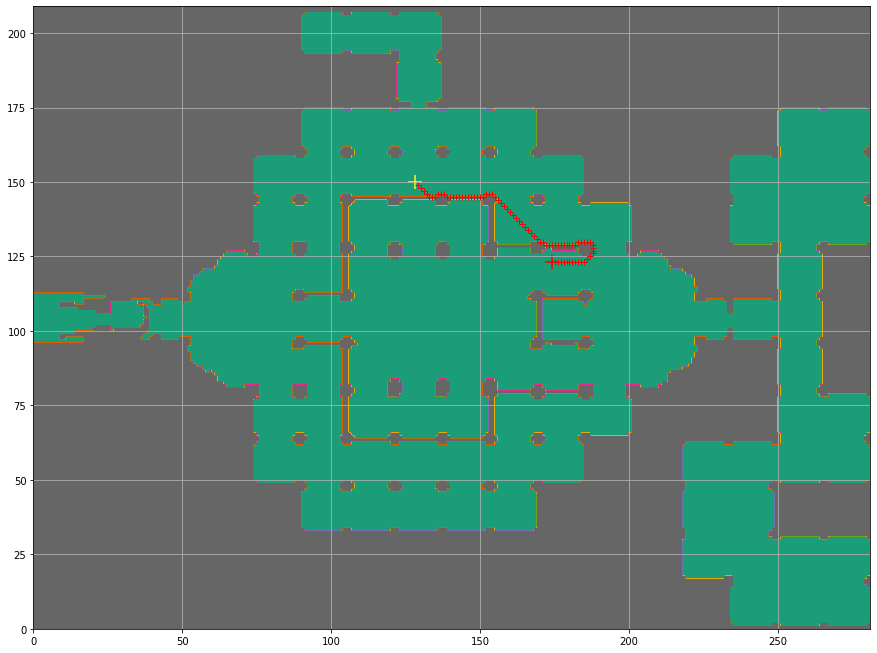

In [3]:
grid_dense = densify_grid(grid)
plot_astar(grid_dense,start,goal,astar_path,extent_limits)

In [4]:
pose = (*astar_path[0],0)
logs = []
path_index = 0
v, w = 0.0, 0.0
while path_index < len(astar_path)-1:
    t0 = time.time()
    local_ref_path = astar_path[path_index:path_index+pred_horizon]
    # update path_index using current pose and local_ref_path
    if euclidean(pose[:2],local_ref_path[-1][:2]) < goal_threshold*4*pred_horizon:
        path_index = path_index + 1
        local_ref_path = astar_path[path_index:path_index+pred_horizon]
    # get next command
    v, w = track(grid_dense,local_ref_path,pose,v,w)
    
    #simulate vehicle for 1 step
    # remember the function now returns a trajectory, not a single pose
    pose = simulate_unicycle(pose,v,w)[-1]
    
    #update logs
    logs.append([*pose, v, w, local_ref_path[-1]])
    t1 = time.time() #simplest way to time-profile your code
    print(f"idx:{path_index}, v:{v:0.3f}, w:{w:0.3f}, current pose: {pose}, tracking point:{local_ref_path[-1][:2]}, time:{(t1-t0) * 1000:0.1f}ms")


Streaming output truncated to the last 5000 lines.
local path has a collision, best_command = (1.2, 0.03927500000000039), cost = 1.7642589396168609
local path has a collision, best_command = (1.2, 0.03927500000000039), cost = 1.7642589396168609
local path has a collision, best_command = (1.2, 0.03927500000000039), cost = 1.7642589396168609
local path has a collision, best_command = (1.2, 0.03927500000000039), cost = 1.7642589396168609
local path has a collision, best_command = (1.2, 0.03927500000000039), cost = 1.7642589396168609
local path has a collision, best_command = (1.2, 0.03927500000000039), cost = 1.7642589396168609
local path has a collision, best_command = (1.2, 0.03927500000000039), cost = 1.7642589396168609
local path has a collision, best_command = (1.2, 0.03927500000000039), cost = 1.7642589396168609
local path has a collision, best_command = (1.2, 0.03927500000000039), cost = 1.7642589396168609
local path has a collision, best_command = (1.2, 0.03927500000000039), cost 

/content/collision_dwa.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  poses = np.array(logs)[:,:3]


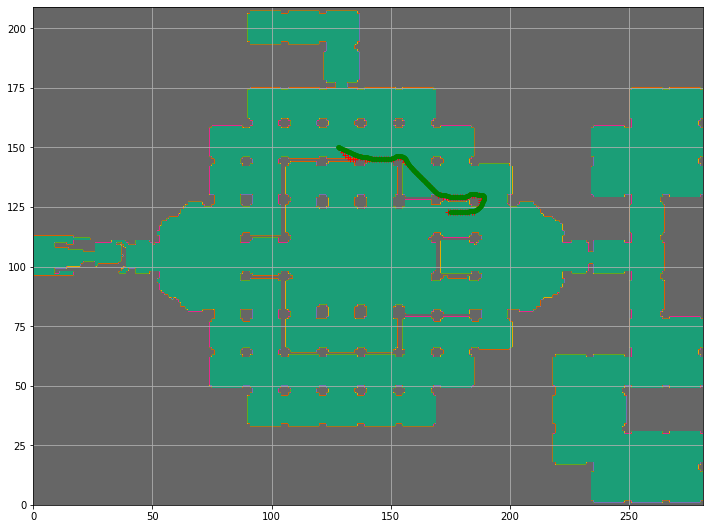

In [6]:
plot_final_path(grid_dense,astar_path,logs,extent_limits)

/content/collision_dwa.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  v = np.array(logs)[:,3]
/content/collision_dwa.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  w = np.array(logs)[:,4]


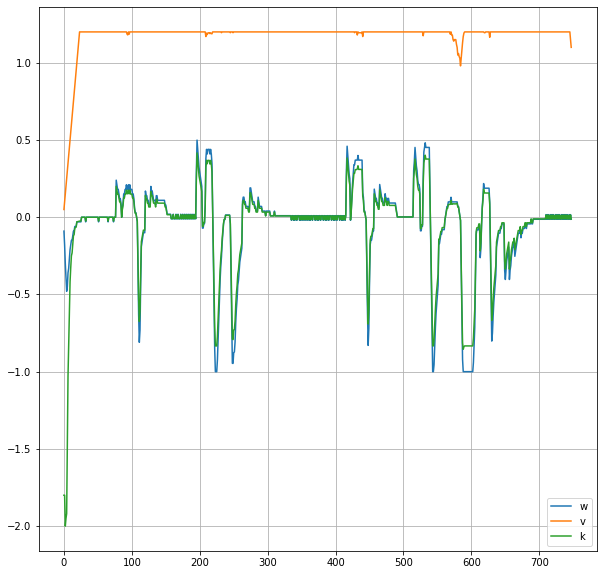

In [7]:
plot_wvk(logs)